In [1]:
import pandas as pd
import numpy as np
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import tqdm
import requests
from bs4 import BeautifulSoup
from google.colab import drive
import datetime
import json
import os
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Get Topic news
# url = ('http://newsapi.org/v2/top-headlines?sources=bbc-news&apiKey=110b7657f0fc4f60954b82bc2c8f78a3')
# url = ('http://newsapi.org/v2/top-headlines?country=us&apiKey=110b7657f0fc4f60954b82bc2c8f78a3')
url = ('http://newsapi.org/v2/everything?pageSize=100&apiKey=110b7657f0fc4f60954b82bc2c8f78a3&q=')
topics = ['live music']
df = pd.DataFrame()
for t in topics:
  response = requests.get(url + t)
  r = response.json()
  # print(r)
  tdf = pd.DataFrame(r['articles'])
  tdf['topic'] = t
  df = pd.concat([df, tdf], ignore_index=True)

df['content_clean'] = df['content'].fillna('no results').map(lambda x: x[:-7])
all_texts = df['content_clean']

In [13]:
df

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'New York Times'}",Jon Pareles,"Globalfest Moves Online, Showcasing World Musi...","With 16 bands over four nights, the festival e...",https://www.nytimes.com/2021/01/15/arts/music/...,https://static01.nyt.com/images/2021/01/15/art...,2021-01-16T00:27:08Z,"Minyo Crusaders set an old Japanese song, from..."
1,"{'id': 'engadget', 'name': 'Engadget'}",Chris Velazco,Spotify just started testing its live lyrics f...,Do you miss all the time you used to spend cra...,https://www.engadget.com/spotify-live-lyrics-u...,https://s.yimg.com/os/creatr-uploaded-images/2...,2021-02-09T14:00:45Z,Do you miss all the time you used to spend cra...
2,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Sarah Perez,Spotify confirms it’s (finally) testing a lyri...,Spotify this morning confirmed it’s testing a ...,http://techcrunch.com/2021/02/09/spotify-confi...,https://techcrunch.com/wp-content/uploads/2019...,2021-02-09T17:00:54Z,Spotify this morning confirmed it’s testing a ...
3,"{'id': 'bbc-news', 'name': 'BBC News'}",None,Covid vaccine patients treated to live organ m...,People listened to the likes of Bach and Hande...,https://www.bbc.co.uk/news/av/uk-55692690,https://ichef.bbci.co.uk/images/ic/400xn/p0947...,2021-01-16T23:31:17Z,About a thousand people over the age of 80 hav...
4,"{'id': 'mashable', 'name': 'Mashable'}",Joseph Green,Mix your own music with a lifetime subscriptio...,TL;DR: A lifetime subscription to the Ableton ...,https://mashable.com/uk/shopping/jan-21-ableto...,https://mondrian.mashable.com/2021%252F01%252F...,2021-01-21T05:05:00Z,TL;DR: A lifetime subscription to the Ableton ...
...,...,...,...,...,...,...,...,...
895,"{'id': None, 'name': 'Slashdot.org'}",EditorDavid,The Rolling Stones Recreate 'Start Me Up' Vide...,Long-time Slashdot reader destinyland writes: ...,https://hardware.slashdot.org/story/21/10/31/0...,https://a.fsdn.com/sd/topics/advertising_64.png,2021-10-31T01:34:00Z,40 years ago the Rolling Stones released the s...
896,"{'id': None, 'name': 'The Guardian'}",by Dalya Alberge,"In Britten’s footsteps, Nitin Sawhney’s requie...",Composer says his music for 60th anniversary o...,https://amp.theguardian.com/music/2021/nov/07/...,https://i.guim.co.uk/img/media/1d8e309be66e6cf...,2021-11-07T08:30:13Z,The 1962 premiere of Benjamin Brittens War Req...
897,"{'id': None, 'name': 'Yahoo Entertainment'}",Associated Press Videos,"Cardinal Dolan blessing of the animals, Rockettes",Cardinal Timothy Dolan kicked off the holiday ...,https://news.yahoo.com/cardinal-dolan-blessing...,https://s.yimg.com/ny/api/res/1.2/DDleoZWKV1dn...,2021-11-02T17:46:10Z,Instagram/Tarrant County Sheriffs OfficeA man ...
898,"{'id': None, 'name': 'CP24 Toronto's Breaking ...",None,9-year-old Dallas boy dies after Astroworld fe...,<ol><li>9-year-old Dallas boy dies after Astro...,https://www.cp24.com/entertainment-news/9-year...,https://www.cp24.com/polopoly_fs/1.5666074.163...,2021-11-15T03:16:00Z,HOUSTON (AP) - A 9-year-old Dallas boy has bec...


In [4]:
# dump json in data_dir
data_dir = 'gdrive/MyDrive/news_archive/'
with open(data_dir + str(datetime.date.today()) + '-' + '_'.join(t.split()) + '.json', 'w') as outfile:
  json.dump(r, outfile)
os.listdir(data_dir)

['2021-02-14-live_music.json',
 '2021-02-17-live_music.json',
 '2021-02-18-live_music.json',
 '2021-02-21-live_music.json',
 '2021-02-22-live_music.json',
 '2021-05-22-live_music.json',
 '2021-05-23-live_music.json',
 '2021-10-31-live_music.json',
 '2021-11-19-live_music.json',
 '2021-11-20-live_music.json']

In [8]:
# df.to_csv(data_dir + 'df.csv')

In [9]:
os.listdir(data_dir)

['2021-02-14-live_music.json',
 '2021-02-17-live_music.json',
 '2021-02-18-live_music.json',
 '2021-02-21-live_music.json',
 '2021-02-22-live_music.json',
 '2021-05-22-live_music.json',
 '2021-05-23-live_music.json',
 '2021-10-31-live_music.json',
 '2021-11-19-live_music.json']

In [15]:
with open(data_dir + '2021-11-20-live_music.json') as fp:
  j = json.loads(fp.read())

{'articles': [{'author': 'Kris Holt',
   'content': 'Amazon\r\n is said to be working on a live audio app that sounds like it will let anyone be the DJ of their own radio show including music. Project Mic, as the app is currently known, will reportedly f… [+1708 chars]',
   'description': 'Amazon\r\n is said to be working on a live audio app that sounds like it will let anyone be the DJ of their own radio show — including music. Project Mic, as the app is currently known, will reportedly focus on the US market at first, though the launch timeline…',
   'publishedAt': '2021-10-26T14:25:34Z',
   'source': {'id': 'engadget', 'name': 'Engadget'},
   'title': 'Amazon’s Clubhouse competitor may let you DJ your own radio show',
   'url': 'https://www.engadget.com/amazon-clubhouse-competitor-project-mic-music-dj-142534929.html',
   'urlToImage': 'https://s.yimg.com/os/creatr-images/2019-10/f9c12d10-f1a7-11e9-b6af-9a9954dc8d2d'},
  {'author': 'Ashley Carman',
   'content': 'A new app is in the 

In [19]:
len(j['articles'])

100

In [17]:
j.keys()

dict_keys(['status', 'totalResults', 'articles'])

In [10]:
# conct all jsons into df
df = pd.DataFrame()
for t in os.listdir(data_dir):
  with open(data_dir + t, 'r') as archive_file:
    arch = json.load(archive_file)
    df = df.append(pd.DataFrame(arch['articles']),ignore_index=True)
df.shape, df.url.nunique()

((900, 8), 399)

In [12]:
df.columns

Index(['source', 'author', 'title', 'description', 'url', 'urlToImage',
       'publishedAt', 'content'],
      dtype='object')

In [ ]:
# drop unusable results
df = df[df.content.notna()]
df.source = df.source.astype(str)
df = df[df.content.notna()].drop_duplicates().reset_index(drop=True)
df['content'] = df['content'].fillna('no results').map(lambda x: x[:-7])

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Get news soup

In [ ]:
for i in tqdm.tqdm(range(df.shape[0])):
  # if df.loc[i,'lang']  == 'en':
  try:
    page = requests.get(df.loc[i].url)
    soup = BeautifulSoup(page.content, 'html.parser')
    content = ''
    for p in range(len(soup.find_all('p'))):
      content += soup.find_all('p')[p].get_text()
    df.loc[i,'soup'] = content
    df.loc[i,'soup_len'] = len(content)
  except Exception as inst:
    print(type(inst)) 
    print('error decoding entry ', i, ': ', df.loc[i].title, ' at ', df.loc[i].url)
    pass
  

 24%|██▍       | 81/338 [00:55<01:28,  2.90it/s]

<class 'requests.exceptions.ConnectionError'>
error decoding entry  79 :  Spotify is bringing full, live lyrics to music streaming in the US  at  https://www.androidpolice.com/2021/02/09/spotify-is-bringing-full-live-lyrics-to-music-streaming-in-the-us/


100%|██████████| 338/338 [04:26<00:00,  1.27it/s]


In [ ]:
# drop unusable results
df = df[df.soup_len > 0].reset_index(drop=True)

In [ ]:
# Extract all persons in text
nlp = spacy.load("en_core_web_sm")
df['Persons'] = df.soup.apply(lambda x: (list(set([entity.text for entity in nlp(x).ents if entity.label_ == 'PERSON']))))
df['Persons_cnt'] = df.Persons.apply(lambda x: len(x))

In [ ]:
df[['Persons','Persons_cnt']].head(2)

,Persons,Persons_cnt
0,"[Nora Brown, Vox Sambou, Sofia Rei, Holm, Adit...",20
1,"[Musixmatch, Deezer, Genius]",3


In [ ]:
def comma_tokenizer(sentence):
    return [str.strip(t) for t in sentence[1:-1].split(',')]

def plot_persons_count_histogram(all_texts):
  vectorizer = CountVectorizer(tokenizer = comma_tokenizer, min_df=2)
  data_vectorized = vectorizer.fit_transform(all_texts)
  word_count = pd.DataFrame({'word': vectorizer.get_feature_names(), 'count': np.asarray(data_vectorized.sum(axis=0))[0]})
  word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh');
  return vectorizer, data_vectorized

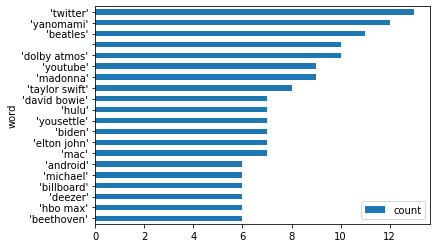

In [ ]:
# 2021-02-22
plot_persons_count_histogram(df.Persons.astype(str));

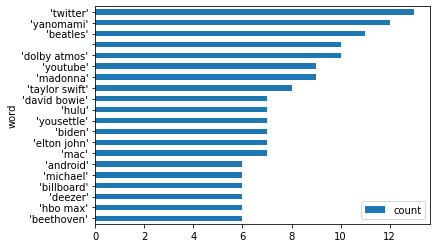

In [ ]:
# 2021-05-23
plot_persons_count_histogram(df.Persons.astype(str));

In [ ]:
pd.set_option('max_colwidth', 300)

In [ ]:
df[['content','soup', 'soup_len']]

,content,soup,soup_len
0,"Minyo Crusaders set an old Japanese song, from a tradition called minyo, to a Nigerian Afrobeat groove. DakhaBrakha, from Ukraine, roved from Eastern European drones and yipping vocals to something l… [+1208","AdvertisementSupported byWith 16 bands over four nights, the festival expanded its reach at a time when live music with audiences is in short supply.Send any friend a storyAs a subscriber, you have 10 gift articles to give each month. Anyone can read what you share.By Jon ParelesMinyo Crusaders ...",5410.0
1,"Do you miss all the time you used to spend crammed in tiny karaoke rooms, belting out showtunes until three in the morning? So do we, but Spotify might have something that will help with your impromp… [+2805","Do you miss all the time you used to spend crammed in tiny karaoke rooms, belting out showtunes until three in the morning? So do we, but Spotify might have something that will help with your impromptu singalongs. As of this morning, the company is now testing a feature that displays lyrics sync...",3043.0
2,"Spotify this morning confirmed it’s testing a new, synced lyrics feature in the U.S. market, following a report from Engadget. Though the streaming music service today offers live lyrics in a number … [+2845","Spotify this morning confirmed it’s testing a new, synced lyrics feature in the U.S. market, following a report from Engadget. Though the streaming music service today offers live lyrics in a number of markets — 27, in fact, including its recent launch in South Korea — it has not offered lyrics ...",3098.0
3,About a thousand people over the age of 80 have been vaccinated at Salisbury Cathedral \r\non its first day of opening as a vaccination centre.The 800-year-old cathedral in south-west England has been … [+210,"This video can not be playedAbout a thousand people over the age of 80 have been vaccinated at Salisbury Cathedral on its first day of opening as a vaccination centre.The 800-year-old cathedral in south-west England has been closed during lockdown, with services taking place online.Its music dir...",2134.0
4,"TL;DR: A lifetime subscription to the Ableton Music Production Mastery Bundle is on sale for £21.32 as of Jan. 21, saving you 97% on list price.\r\nClaire Boucher (Grimes), the 30-year-old pop-electron… [+1884","TL;DR: A lifetime subscription to the Ableton Music Production Mastery Bundle is on sale for £21.32 as of Jan. 21, saving you 97% on list price.Claire Boucher (Grimes), the 30-year-old pop-electronic musician from Vancouver has made a name for herself as a fiercely independent artist. She record...",2014.0
...,...,...,...
326,"Halloween 2021 is shaping up to be a big one as revelers seek to make up for the mid-pandemic bummer of last fall. People are vaxxed, masked, and ready to embrace jump scares instead of the very real… [+5819","Halloween 2021 is shaping up to be a big one as revelers seek to make up for the mid-pandemic bummer of last fall. People are vaxxed, masked, and ready to embrace jump scares instead of the very real terror of the past year and a half. It’s all the more reason you should create a haunted house i...",6737.0
327,"Evolving the future of the piano industry, the historic brand unveils technology that allows a piano to play itself in time with live performances from renowned pianists\nWhen Steinway & Sons launched… [+4000","COOL HUNTING®Informing the future since 2003 \n window.dataLayer = window.dataLayer || [];\n window.dataLayer.push({\n 'event': 'ContentDisplayed',\n 'contentDisplayedId': '272356',\n 'contentDisplayedPermalink': 'https://coolhunting.com/design/steinway-s...",5377.0
328,"Swedish climate activist Greta Thunberg danced and sang in front of an audience to the 1980s song ""Never Gonna Give You Up,"" which in recent years is best known for ""Rickrolls,"" during a climate conc… [+1788","Swedish climate activist Greta Thunberg danced and sang in front of an audience to the 1980s song ""Never Gonna Give You Up,"" whi

## tokenizers

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=[ "ner"])

def spellcheck_tokenizer(sentence):
    return ' '.join([word.text 
                    for word in nlp(sentence)])
spellcheck_tokenizer("Hi, what's this blurb asdfsadf?")


"Hi , what 's this blurb asdfsadf ?"

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])
nlp.max_length = 2000000

def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]


In [ ]:
ner = spacy.load("en_core_web_sm", disable=["tagger", "parser"])

def ner_tokenizer(sentence):
    return [ent.text for ent in ner(sentence).ents ]


In [ ]:
def plot_word_count_histogram(pd_series):
  vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, min_df=2)
  data_vectorized = vectorizer.fit_transform(all_texts)
  word_count = pd.DataFrame({'word': vectorizer.get_feature_names(), 'count': np.asarray(data_vectorized.sum(axis=0))[0]})
  word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh');
  return vectorizer, data_vectorized

## Work on headlines

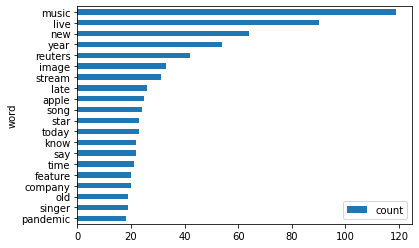

In [ ]:
all_texts = df['content']
plot_word_count_histogram(all_texts);

## Work on soup

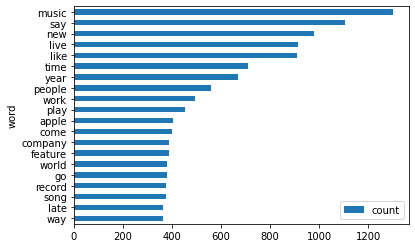

In [ ]:
all_texts = df[df.soup_len > 0].soup
vectorizer, data_vectorized = plot_word_count_histogram(all_texts)

## Run KMeans on TfIdf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def vectorize(text, maxx_features):   
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X, vectorizer

In [ ]:
os.listdir(data_dir)text = all_texts.values
X, vectorizer = vectorize(text, 2 ** 12)
X.shape

(331, 4096)

In [ ]:
pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(331, 257)

In [ ]:
# run kmeans with many different k
distortions = []
K = range(2, 10)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

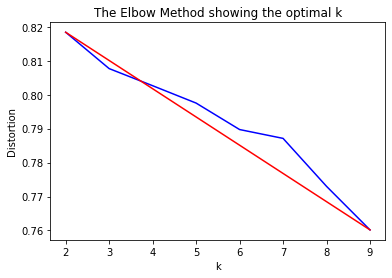

In [ ]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
k_means = KMeans(n_clusters=5, random_state=42).fit(X_reduced)

In [ ]:
df.loc[df.soup_len > 0, 'cluster'] = k_means.labels_

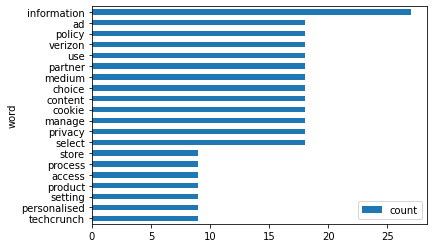

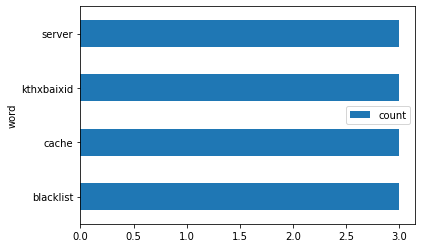

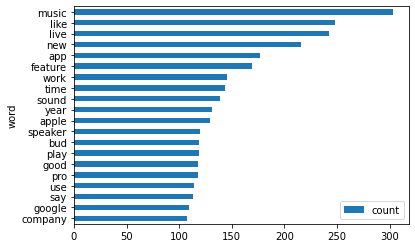

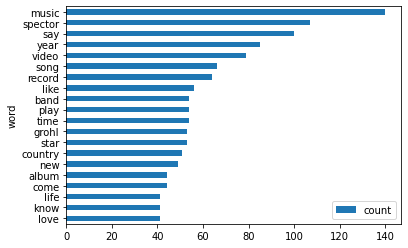

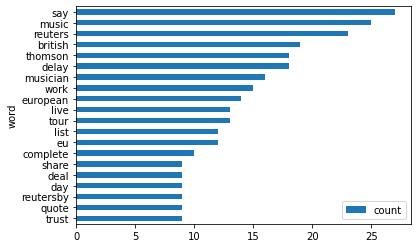

In [ ]:
for c in range(5):
  all_texts = df[df.cluster==c].soup
  vectorizer, data_vectorized = plot_word_count_histogram(all_texts);

In [ ]:
df.cluster.value_counts()

2    78
3    25
4     9
0     9
1     3
Name: cluster, dtype: int64

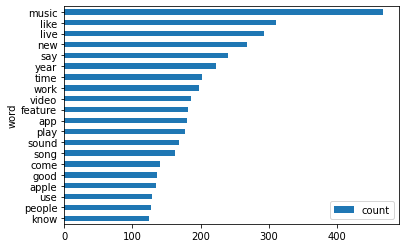

In [ ]:
# get rid of unusable text
df = df[df.cluster > 1].reset_index(drop=True)
all_texts = df.soup
vectorizer, data_vectorized = plot_word_count_histogram(all_texts);

## Find topics with LDA

In [ ]:
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(data_vectorized)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
def print_top_words(model, vectorizer, n_top_words):
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [ ]:
print_top_words(lda, vectorizer, n_top_words=20)

IndexError: ignored


## Semantic text similarity

Using WordNet
**Path similarity**: sim(a,b) = 1/len(path(a,b)

Use **LCS** (lowest common subsumer), e.g. LCS(dachshound,greyhound)=dog

lin_sim(a,b)=2*log(P(LCS(u,v))/(log(P(u))+log(P(v)))


In [ ]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
wn.path_similarity(wn.synset('dog.n.01'), wn.synset('cat.n.01'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Unzipping corpora/genesis.zip.


colocation and distributional similarity:

Pointwise mutual information: PMI(w,c)=log(P(w,c)/P(w)P(c))

In [ ]:
from nltk.collocations import *
nltk.download('genesis')
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(nltk.corpus.genesis.words('english-web.txt'))
finder.nbest(bigram_measures.pmi, 10)


[('Allon', 'Bacuth'),
 ('Ashteroth', 'Karnaim'),
 ('Ben', 'Ammi'),
 ('En', 'Mishpat'),
 ('Jegar', 'Sahadutha'),
 ('Salt', 'Sea'),
 ('Whoever', 'sheds'),
 ('appoint', 'overseers'),
 ('aromatic', 'resin'),
 ('cutting', 'instrument')]

# Topic modeling

Coarse level analysis of what's in a text collection

topics are represented as word distributions: 
- sports will have high proba of ball, player, etc.
- player can appear in economy, but less likely

take a corpus, a number of topics
find actual topics, topic distribution for each doc
simultaneous text and words clustering

LDA: generative model for a doc d:
- choose length of d
- choose mixture of topics
- use topic distrib to generate d

topics are word distributions.
preprocess text and then convert docs to doc-term matrix





### Analyse Topic 0

In [ ]:
topic_spread = pd.DataFrame(lda.transform(data_vectorized))
#pd.Series(spacy_tokenizer(df.loc[177,'soup'])))
topic_spread[0]

0      0.001807
1      0.001343
2      0.001229
3      0.001305
4      0.000207
         ...   
450    0.001088
451    0.037937
452    0.000911
453    0.239826
454    0.000562
Name: 0, Length: 455, dtype: float64

In [ ]:
topic_spread[0].sort_values()

238    0.000039
147    0.000078
78     0.000119
447    0.000136
105    0.000144
         ...   
177    0.999091
329    0.999103
364    0.999108
135    0.999201
167    0.999223
Name: 0, Length: 455, dtype: float64

In [ ]:
df_soup = df.loc[df.soup_len > 0].reset_index(drop=True)
x = ' '.join(spacy_tokenizer(df_soup.loc[167,'soup']))
np.sum([1 if w in ['var','read','function','time','new','action','rest','event','day','view','form','advertise'] else 0 for w in x.split()])

90

In [ ]:
df_soup['topic0'] = topic_spread[0]

In [ ]:
df_soup['word0'] = all_texts.map(lambda x : np.sum([1 if w in ['var','read','function','time','new','action','rest','event','day','view','form','advertise'] else 0 for w in x.split()]))

In [ ]:
df_soup[df_soup.topic0 > .95].soup

64     \r\nRight after astronauts Apollo 11 astronauts Neil A. Armstrong, Edwin E. “Buzz” Aldrin, and Michael Collins splashed down in the Pacific Ocean on July 24, 1969, they were brought aboard the USS Hornet (CVS-12) and immediately entered a Mobile Quarantine Facility (MQF) along with a NASA flight...
135    While all the downsides of stay-at-home orders and social distancing are evident, there are at least a few small silver linings to come out of all this. For many, this time spent indoors has meant a happy reintroduction to your very own kitchen.You know your kitchen. It’s usually the place that ...
136    Do you have more leftovers that usual? We sure do. We were running out of food storage containers so I bought a 9-pack of these 16-0unce twist-lock containers. The fact that they have leak-proof lids that won't come off when you drop them is key. They're also dishwasher safe.  The problem with u...
167    For those who have spent years lamenting the fact that they never seem t

In [ ]:
df['covid'] = all_texts.str.lower().str.contains('coronavirus') | all_texts.str.lower().str.contains('covid')
df.groupby('topic')['covid'].sum()

topic
cooking      16.0
face-mask    43.0
nasa          6.0
nasdaq       31.0
weather      25.0
Name: covid, dtype: float64

## Get article language

In [ ]:
nlp.add_pipe(nlp.create_pipe('sentencizer'))
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)



In [ ]:
lang = all_texts.map(lambda x : nlp(x)._.language['language'])
score = all_texts.map(lambda x : nlp(x)._.language['score'])
langs = pd.DataFrame({'content':all_texts, 'lang':lang, 'score':score})

In [ ]:
langs.lang.value_counts()

en    463
pt     31
de      2
es      2
ca      1
et      1
Name: lang, dtype: int64

In [ ]:
df['lang'] = lang

# Classify news

In [ ]:
!pip install transformers


In [ ]:
import tensorflow as tf
import torch
from transformers import BertTokenizer

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
df_clean = df[['soup','topic']].dropna().copy()
df_clean.shape

(455, 2)

In [ ]:
sentences = df_clean.soup.values
labels = df_clean.topic.values

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  NASA and Planet  have deemed their pilot partnership a success, and the result is that NASA will extend its contract with Planet to provide the company’s satellite imagery of Earth to all research programs funded by the agency. NASA had signed an initial contract last April with Planet to provide Planet imagery to a team of 35 researchers working on tracking what are known as “Essential Climate Variables,” or ECVs.The ECV trial showed that Planet’s imagery was useful in tracking and providing insight into a number of different Earth-based environmental events, including landslides in the Himalayan mountain range. During the study, one of the key ingredients in helping researchers detect early warning signs was the Planet satellite constellation’s high revisit rate, which means the frequency with which it photographs a specific area over time.Planet’s data covers the entire Earth at least once per day, and includes even areas of the planet not typically included in Earth obs

In [ ]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True, max_length=256)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  256


In [ ]:
print(' Original: ', sentences[1])

 Original:  The huge mirror of NASA&aposs James Webb Space Telescope -- its successor to Hubble -- has been successfully tested for the first time, putting it one step closer to its eventual launch, which is slated for 2021. Like Hubble -- which has long outlived its original lifespan but is expected to remain operational for a few years yet -- the James Webb will investigate celestial bodies from our solar system and beyond.Getting the new telescope to this stage has been a challenging endeavor for NASA -- its launch was initially scheduled for 2018, but the intricacy of construction, number of parts needed and the fact that it&aposs the most complex telescope built to date meant its launch date has seen a series of delays.Now though, following the successful test, researchers are confident it&aposs on track for launch next year. The test procedure involved replicating Webb&aposs final configuration in a space-like environment. This meant replicating the zero-gravity atmosphere Webb w

In [ ]:
df_clean['label'] = df_clean['topic'].factorize()[0]
labels = df_clean.label.values

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
# print('Original: ', sentences[0])
# print('Token IDs:', input_ids[0])

In [ ]:
input_ids[0][0:10]

tensor([ 101, 9274, 1998, 4774, 2031, 8357, 2037, 4405, 5386, 1037])

In [ ]:
train_dataset.indices[0:10]

[227, 222, 210, 253, 296, 270, 248, 56, 188, 342]

In [ ]:
tokenizer.tokenize(df_clean.loc[227]['soup'])[0:10]
tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df_clean.loc[227]['soup']))[0:10]

[1017, 8117, 3191, 1006, 26665, 1007, 1011, 2813, 2395, 18303]

In [ ]:
 train_dataloader

In [ ]:
for i in train_dataloader:
  print(i[0].to(device))

In [ ]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
# MH: why?
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

In [ ]:
pd.Series(labels.numpy()).value_counts()

0    94
3    92
4    90
2    90
1    89
dtype: int64

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 5,  output_attentions = False, output_hidden_states = False)
model.cuda()

# Get all of the model's parameters as a list of tuples.

see https://mccormickml.com/2019/07/22/BERT-fine-tuning/
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))   
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_train_loss = 0
    total_train_accuracy = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss, `loss` is a Tensor containing a single value; 
        total_train_loss += loss.item()
        total_train_accuracy += flat_accuracy(logits.detach().cpu().numpy(),
                                              b_labels.to('cpu').numpy())

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()


    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)             
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
        
    #########               Validation

    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    epoch_time = format_time(time.time() - t0)
    
    print(" Epoch %d" % (int(epoch_i) + 1),
          " Train %.2f" % avg_train_loss,
          " Accuracy %.2f" % avg_train_accuracy, 
          " Validation %.2f" % avg_val_loss , 
          " Accuracy %.2f" % avg_val_accuracy, 
          " took {:}".format(epoch_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accur.': avg_train_accuracy,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

 Epoch 1   Train 1.15  Accuracy 0.70  Validation 1.10  Accuracy 0.70  took 0:00:01
 Epoch 2   Train 0.98  Accuracy 0.79  Validation 0.96  Accuracy 0.72  took 0:00:01
 Epoch 3   Train 0.82  Accuracy 0.86  Validation 0.86  Accuracy 0.73  took 0:00:01
 Epoch 4   Train 0.75  Accuracy 0.87  Validation 0.83  Accuracy 0.77  took 0:00:01
 Epoch 5   Train 0.73  Accuracy 0.87  Validation 0.83  Accuracy 0.77  took 0:00:01

Training complete!
Total training took 0:02:57 (h:mm:ss)


In [ ]:
import pandas as pd

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,1.15,0.70,1.10,0.70,0:00:34,0:00:01
2,0.98,0.79,0.96,0.72,0:00:34,0:00:01
3,0.82,0.86,0.86,0.73,0:00:34,0:00:01
4,0.75,0.87,0.83,0.77,0:00:34,0:00:01
5,0.73,0.87,0.83,0.77,0:00:34,0:00:01


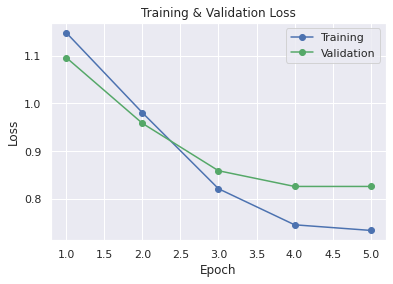

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

sns.set(style='darkgrid')
# sns.set(font_scale=1.5)
#plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.xticks([1, 2, 3, 4])
plt.show()

In [ ]:
for batch in validation_dataloader:
    
    # Unpack this training batch from our dataloader. 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():        
        (loss, logits) = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
        

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    print(len(label_ids))


32
14


In [ ]:
np.argmax(logits, axis=1).flatten()

array([4, 3, 1, 1, 0, 2, 0, 0, 3, 1, 2, 1, 2, 3])

In [ ]:
label_ids

array([4, 3, 4, 1, 0, 1, 0, 0, 1, 1, 2, 1, 2, 3])

In [ ]:
for p, a in zip(np.argmax(logits, axis=1).flatten(), label_ids):
  if p != a:
    print(p, a)

1 4
2 1
3 1


In [ ]:
batch

[tensor([[  101,  4419,  2739,  ...,     0,     0,     0],
         [  101,  2123,  1005,  ...,  1996,  3815,   102],
         [  101,  1045,  4687,  ...,  2013, 23885,   102],
         ...,
         [  101, 27166,  3388,  ...,  1997,  2712,   102],
         [  101, 15768,  2736,  ...,  2005,  1996,   102],
         [  101,  2215,  2000,  ...,  2027,  2071,   102]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([4, 3, 4, 1, 0, 1, 0, 0, 1, 1, 2, 1, 2, 3])]